# Resolution of a Phase-Field problem using PINN
### main references: (Raissi et al.2019, J. Berg 2018 ..)

We focuse in a first order on solving the Allen-Cahn equation and the Cahn-Hilliard equation .
. The specific expression of the Ginzburg-Landau free energy
$$
F=\int_\omega \frac{\gamma_1}{2}|\nabla \phi|^2+\frac{\gamma_2}{4}\left(\phi^2-1\right) d \mathbf{x},
$$
where $\gamma_1$ and $\gamma_2$ are parameters: could be defined as interface gradient and chemical energy coefficients in this order.

 If we take the $L^2$ gradient flow, we obtain the Allen-Cahn equation
$$
\partial_t \phi=\gamma_1 \Delta \phi+\gamma_2\left(\phi-\phi^3\right) ;
$$



If we take the $H^{-1}$ gradient flow, we obtain the Cahn-Hilliard equation
$$
\partial_t \phi=\Delta\left(-\gamma_1 \Delta \phi+\gamma_2\left(\phi^3-\phi\right)\right) .
$$



Thermodynamically consistent boundary conditions (such as periodic boundary conditions and homogeneous Neumann boundary conditions) and initial values shall be proposed to close the system.

AC equation could be also written in another simplified form by choosing a phasefield-dependant chemical energy and interface term: 

$
f(\phi)=-\phi(\phi-1)(\phi+1)
$

$
\dfrac{\partial \eta}{\partial t}=
f(\phi)+\nabla^{2}\phi
$


Note that this form was used to study 2D Grain Growth using FD-based phase-field code.

In order to validate a first PINN solution using AC, we propose this equivalent form with numerical values of the coefficients:

\begin{aligned}
& \phi_t-0.0001 \phi_{x x}+5 \phi^3-5 \phi=0, \quad x \in[-1,1], \quad t \in[0,1] \\
& \phi(0, x)=x^2 \cos (\pi x) :     IC\\ 
& \phi(t,-1)=\phi(t, 1) : BC\\
\end{aligned}

Here it is recommended to consider a problem IC and BC, as we assume that IC allows the PINN to well predict the intial solution (t=0). If this prediction is false, then the error would dramatically propagate.

# ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- Numerical Implementation --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [179]:
!pip install pyDOE

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: /usr/bin/python3 -m pip install --upgrade pip


In [180]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
import math
# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)
import random
import datetime
import shutil
print("TensorFlow version: {}".format(tf.__version__))
import random

TensorFlow version: 2.11.0


In [181]:
# define  Collocations points
N_ini = 50   #Total number of data points for 'u': IC
N_f = 5000   #Total number of collocation points : domain
N_obs = 50   # Total number of observation points (if applicable)
N_b=100     # Total number of data points for 'u': boundary BC

In [182]:
N_t_x=N_b
x=np.linspace(-1, 1, N_t_x)
x=np.expand_dims(x, axis=1)

t=np.linspace(0, 1, N_t_x)
t=np.expand_dims(t, axis=1)

X, T = np.meshgrid(x,t)                         # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple
lb = np.array([x.min(), t.min()])  # Domain bounds
ub = np.array([x.max(), t.max()])  # Domain bounds
idx_t = np.random.choice(t.shape[0], N_b, replace=True)
tb = t[idx_t,:]
X_flat = X.flatten()
T_flat = T.flatten()

In [183]:
data = scipy.io.loadmat('AC.mat')  	# Load data from file
x1 = data['x'][::,::2].transpose()                                   # 256 points between -1 and 1 [256x1]
t1 = data['tt'][::,::2].transpose()                                    # 100 time points between 0 and 1 [100x1] 
usol = data['uu'][::2,::2] 
sample_indices = np.random.choice(len(X_flat), size=N_obs, replace=False)
X_train_obs = np.stack((X_flat[sample_indices], T_flat[sample_indices]), axis=1)
u_train_obs = usol.flatten()[sample_indices].reshape(-1, 1)
                           # solution of 256x100 grid points
#data.keys()

Text(0.5, 1.0, 'Exact solution')

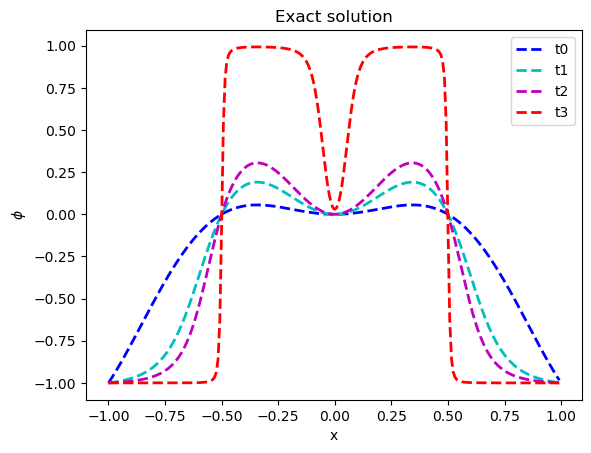

In [184]:
plt.plot(x1,usol.T[0,:], 'b--', linewidth = 2, label = 't0')   
plt.plot(x1,usol.T[25,:], 'c--', linewidth = 2, label = 't1')   
plt.plot(x1,usol.T[35,:], 'm--', linewidth = 2, label = 't2')  
plt.plot(x1,usol.T[-1,:], 'r--', linewidth = 2, label = 't3')   
plt.legend()
plt.ylabel(r"$\phi$")
plt.xlabel(r"x")
plt.title("Exact solution")

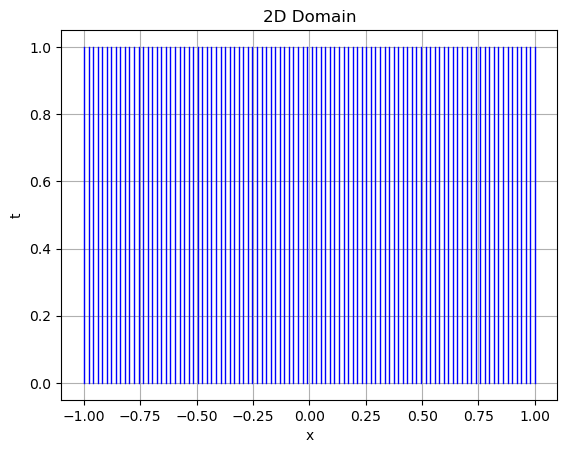

In [185]:
# plot 2D domain
plt.figure()
plt.plot(X, T, 'b-', linewidth=1)
plt.xlabel('x')
plt.ylabel('t')
plt.title('2D Domain')
plt.grid()
plt.show()

In [186]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) 

# Domain bounds
#lb = X_u_test[0]  # [-1. 0.]
#ub = X_u_test[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [51200x1] 
'''
#u = usol.flatten('F')[:,None] 

"\n   Fortran Style ('F') flatten,stacked column wise!\n   u = [c1 \n        c2\n        .\n        .\n        cn]\n\n   u =  [51200x1] \n"

In [187]:
def set_train_data(N_ini,N_f,tb):

    '''Boundary Conditions'''

    #Initial Condition -1 =< x =<1 and t = 0  
    all_x_IC= np.hstack((X[0,:][:,None], T[0,:][:,None])) 
    all_u_IC = x**2 * np.cos(np.pi* x) 
    print(all_u_IC.shape)
  
    idx_ini = np.asarray(sorted(np.random.choice(all_x_IC.shape[0], N_ini,replace=False))) #replace=False

    X_ini_train = all_x_IC[idx_ini,:] #choose indices from  set 'idx' (x,t)
    u_ini_train = all_u_IC[idx_ini,:] #choose indices from  set 'idx' (x,t)

    '''Collocation Points'''
    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    X_f_train = lb + (ub-lb)*lhs(2,N_f)

    #Boundary Condition x = -1 and 0 =< t =<1 
    X_lb_train = np.concatenate((0*tb + lb[0], tb), 1)

    #Boundary Condition x = 1 and 0 =< t =<1
    X_ub_train = np.concatenate((0*tb + ub[0], tb), 1)
    #X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 

    X_ini_train[:, 1] = 0

    print('X_f_train: {0}, X_ini_train: {1}, X_lb_train: {2}, X_ub_train: {3}, u_ini_train: {4}'.format(X_f_train.shape,\
    X_ini_train.shape,X_lb_train.shape,X_ub_train.shape,u_ini_train.shape))
          
    return X_f_train, X_ini_train,X_lb_train,X_ub_train,u_ini_train

In [188]:
X_f_train, X_ini_train,X_lb_train,X_ub_train,u_ini_train=set_train_data(N_ini,N_f,tb)

(100, 1)
X_f_train: (5000, 2), X_ini_train: (50, 2), X_lb_train: (100, 2), X_ub_train: (100, 2), u_ini_train: (50, 1)


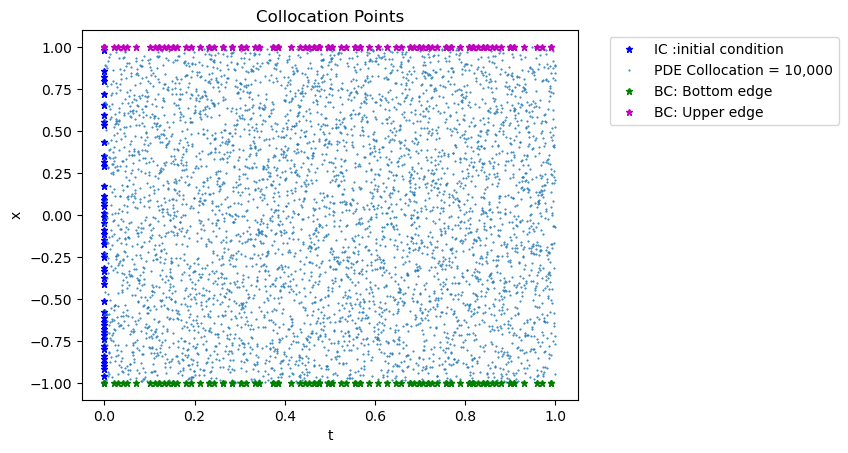

In [189]:
# Training datafig,ax = plt.subplots()

# plt.plot(X_obs_train[:,1], X_obs_train[:,0], '*', color = 'red', markersize = 5, label = 'Boundary collocation = 100')
plt.plot(X_ini_train[:,1], X_ini_train[:,0], '*', color = 'b', markersize = 5, label = 'IC :initial condition')
plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE Collocation = 10,000')
plt.plot(X_lb_train[:,1], X_lb_train[:,0], '*', color = 'g', markersize = 5, label = 'BC: Bottom edge')
plt.plot(X_ub_train[:,1], X_ub_train[:,0], '*', color = 'm', markersize = 5, label = 'BC: Upper edge')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Collocation Points')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#fig.savefig('collocation_points.png', dpi = 500, bbox_inches='tight')

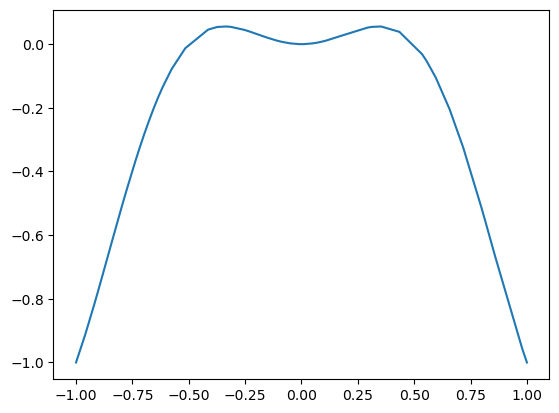

In [190]:
plt.plot(X_ini_train[:,0], u_ini_train)

In [191]:
def EraseFile(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [192]:
pathOutput = os.getcwd() + '/save_figs'
if not os.path.isdir(pathOutput):
    os.mkdir(pathOutput)

In [193]:
def plot_domain(X_ini_train,X_f_train,X_ub_train,X_lb_train,t_min, t_max,batch_idx):
    pathOutput = os.getcwd() + '/save_figs'
    plt.figure()
    plt.plot(X_ini_train[:,1], X_ini_train[:,0], '*', color = 'b', markersize = 5, label = 'IC :initial condition')
    plt.plot(X_f_train[:,1], X_f_train[:,0], 'o', markersize = 0.5, label = 'PDE Collocation')
    plt.plot(X_lb_train[:,1], X_lb_train[:,0], '*', color = 'g', markersize = 5, label = 'BC: Bottom edge')
    plt.plot(X_ub_train[:,1], X_ub_train[:,0], '*', color = 'm', markersize = 5, label = 'BC: Upper edge')

    plt.xlabel('t')
    plt.ylabel('x')
    plt.title('Collocation Points')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    title="Training domain for Batch "+ str(batch_idx)+" for: " +'t_min: {0:.1f}, t_max: {1:.1f}'.format(t_min, t_max)
    plt.savefig(os.path.join(pathOutput ,title+ ".png"))
    plt.close()

def solutionplot(u_pred,X_u_train):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    #ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' , markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[35]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[-1]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title(r'$\phi(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 4)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x1,usol.T[0,:], 'b--', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[0,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi(x,t)$')    
    ax.set_title('$t = 0$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x1,usol.T[15,:], 'b--', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[15,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.5$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x1,usol.T[35,:], 'b--', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[35,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)


    ax = plt.subplot(gs1[0, 3])
    ax.plot(x1,usol.T[-1,:], 'b--', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[-1,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\phi(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 1$', fontsize = 10)
    
    plt.savefig('results.png',dpi = 500) 

In [194]:
import random

# Generate an array of random numbers with a total length of 100
arr = [random.randint(0, 100) for i in range(100)]

# Calculate 10% of the length of the array
percent = 0.1
num_elements = int(len(arr) * percent)

# Select the first 10% of the array using slicing
selected = arr[:num_elements]

# Print the selected elements
print(selected)

[100, 8, 29, 57, 5, 59, 51, 88, 70, 7]


In [195]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        ###############################################
        self.X_f=X_f_train             
        self.X_ini=X_ini_train
        self.X_lb=X_lb_train
        self.X_ub=X_ub_train
        self.u_ini=u_ini_train

        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim

        ###############################################
        # Define the Adam optimizer
        self.optimizer_Adam = tf.keras.optimizers.Adam(learning_rate=0.0001) 
        """
        # Define the Scipy L-BFGS-B optimizer
        self.scipy_optimizer=scipy.optimize(fun = self.optimizerfunc, 
                                          x0 = init_params, 
                                          args=(), 
                                          method='L-BFGS-B', 
                                          jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                          callback = PINN.optimizer_callback, 
                                          options = {'disp': None,
                                                    'maxcor': 200, 
                                                    'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                                    'gtol': 5e-8, 
                                                    'maxfun':  100, 
                                                    'maxiter': 100,
                                                    'iprint': -1,   #print update every 50 iterations
                                                    'maxls': 50})      
        """   

    ###############################################
    """
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        a = x

        for i in range(len(layers)-2):
            a = tf.expand_dims(a, axis=0)
            a = tf.keras.layers.LSTM(units=layers[i+1], return_sequences=True, activation='tanh')(a)
            a = tf.squeeze(a, axis=0)

        a = tf.matmul(a, self.W[-2]) + self.W[-1] # For regression, no activation to last layer
        return a
    """
    ###############################################
 
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)   
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a

    ###############################################
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
    ###############################################    
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 
    ###############################################
    def loss_IC(self,x_ini,u_ini):                                         
        loss_IC = tf.reduce_mean(tf.square(u_ini-self.evaluate(x_ini)))
        return loss_IC
    ###############################################
    def loss_BC(self,x_lb,x_ub):   
        pred_lb=self.evaluate(x_lb)
        pred_ub=self.evaluate(x_ub)
        loss_u =  tf.reduce_mean(tf.square(pred_lb+1))+tf.reduce_mean(tf.square(pred_ub+1))  #+tf.reduce_mean(tf.square(pred_lb-pred_ub)) 
        return loss_u
    ###############################################
    def loss_PDE(self, X_f):
    
        g = tf.Variable(X_f, dtype = 'float64', trainable = False)

        x_f = g[:,0:1]
        t_f = g[:,1:2]
        #print("x_f.shape,t_f.shape :",t_f.shape,t_f.shape)

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1) 
            #print("g.shape :",g.shape)  

            u = self.evaluate(g)
            u_x = tape.gradient(u,x_f)

        u_t = tape.gradient(u,t_f)    
        u_xx = tape.gradient(u_x, x_f)

        del tape

        #f_chem=  -5 *z*(z**2-1)
        f =  u_t - 0.0001 * u_xx + 5.0 * u**3 - 5.0 * u

        loss_f = tf.reduce_mean(tf.square(f))
        
        return loss_f
    ###############################################
    def loss(self,xf,x_ini,x_lb,x_ub,u_ini):
        
        loss_IC = self.loss_IC(x_ini,u_ini)      
        
        loss_f =self.loss_PDE(xf) 
        loss_BC = self.loss_BC(x_lb,x_ub) 
        loss = loss_IC + loss_BC+ loss_f
        
        return loss, loss_BC,loss_IC, loss_f
    ###############################################
    def optimizerfunc_batch(self,parameters):
        #print("in optimizerfunc_batch")
        batch_size=32
        self.set_weights(parameters)
        optimizer = self.optimizer_Adam
        
        # Create dataset from training data
        dataset = tf.data.Dataset.from_tensor_slices(self.X_f)

        #dataset = dataset.shuffle(buffer_size=X_u_train.shape[0])

        #Apply minibatching to the dataset
        dataset = dataset.batch(batch_size=batch_size)
        
        loss_val = 0.0
        loss_u = 0.0
        loss_IC = 0.0
        loss_f = 0.0
        
        for batch in dataset:
            #X_batch, u_batch = batch

            with tf.GradientTape() as tape:
                tape.watch(self.trainable_variables)

                # Compute losses for the batch
                batch_loss_val, batch_loss_BC, batch_loss_IC, batch_loss_f = self.loss(self.X_f,self.X_ini,self.X_lb,self.X_ub,self.u_ini)

            # Compute gradients for the batch
            grads = tape.gradient(batch_loss_val, self.trainable_variables)

            # Update the parameters using the gradients
            optimizer.apply_gradients(zip(grads, self.trainable_variables))
            
            # Accumulate losses across all batches
            loss_val += batch_loss_val.numpy()
            loss_u += batch_loss_BC.numpy()
            loss_IC += batch_loss_IC.numpy()
            loss_f += batch_loss_f.numpy()
                    
        # Compute average losses across all batches
            loss_val += batch_loss_val.numpy()
        n_batches = int(np.ceil((self.X_f).shape[0] / batch_size))
        loss_val /= n_batches
        loss_u /= n_batches
        loss_IC /= n_batches
        loss_f /= n_batches
        
        return loss_val, loss_u, loss_IC, loss_f
    ###############################################
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_BC,loss_IC, loss_f = self.loss(self.X_f,self.X_ini,self.X_lb,self.X_ub,self.u_ini)   
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    ###############################################
    def print_final_loss(self,x):
        # Wrap the original callback function to print the final loss value
        def wrapped_callback(x):
            if not wrapped_callback.done:
                self.optimizer_callback(x)
                wrapped_callback.done = True

        wrapped_callback.done = False
        results = self.optimizer_callback(x)

        # Print the final loss value
        
        tf.print(results.fun)

        return results
    ###############################################
    def save_predictions(self, epoch,pathOutput,X_u_test,\
                         X_ini,u_ini,N_b,epoch_print):
        if (epoch + 1) % epoch_print == 0: 
            u_pred = self.evaluate(X_u_test)
            u_pred = np.reshape(u_pred,(N_b,10),order='F')  # 10 time intervals
            #------------------------------------
            # plot
            # for real time control (show predictions)
            plt.figure() 
            n_intervals = 4
            t_step = len(u_pred.T) // n_intervals

            plt.plot(X_ini[:,0],u_ini[:,0],'b--', linewidth = 2, label = "U_ini_true")
            
            for i in range(n_intervals):
                color_ =['c','m','g','orange']
                t_idx = i * t_step
                label = 't_{}'.format(t_idx)+"_pred"
                plt.plot(x, u_pred.T[t_idx, :], '--', linewidth=2,color=color_[i], label=label)            
            color_ = tuple(np.random.rand(3))
            plt.plot(x, u_pred.T[-1, :], 'r--', linewidth=2, label='t_f')
            plt.legend()                            
            filename="u_pred_epoch_"+str(epoch+1)
            plt.savefig(os.path.join(pathOutput ,filename))
            plt.close()
    ###############################################
    def plot_ini(self,batch_X_ini,batch_u_ini,X_ini,u_ini):
        #print(batch_X_ini.shape,batch_u_ini.shape)
        plt.plot( batch_X_ini[:,0], batch_u_ini,'o')
        #plt.plot(X_ini[:,0], u_ini)
        #plt.show()
    ###############################################
    def optimizer_callback(self,parameters):
        global Nfeval
                       
        total_loss,loss_BC,loss_IC, loss_f = self.loss(self.X_f,self.X_ini,self.X_lb,self.X_ub,self.u_ini)  
        
        #u_pred = self.evaluate(X_u_test)
        #error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)
        if Nfeval % 1000 == 0:       # how much to print during scipy iterations
                  tf.print('Iter: {0:d}, total_loss: {1:.3e}, loss_BC: {2:.3e}, loss_IC: {3:.3e}, loss_f: {4:.3e}'.format(Nfeval, total_loss, loss_BC,loss_IC, loss_f))
        Nfeval += 1
   ###############################################
    def train(self,epochs,batch_size,epoch_scipy_opt=1000,epoch_print=500, resample=False,\
              initial_check=False):  
 
        # time intervals 
        num_train_intervals=10
        time_subdomains=np.linspace(0,1,num_train_intervals+1)
        count=0
        # init
        X_ini=self.X_ini
        u_ini=self.u_ini
        # loss
        global Nfeval
        list_loss=[]
        # dummy params
        flag=0
        thresh= 1e-4 #1e-3
        percent=1
 
        # shuffle Collocation points
        idx = np.random.permutation(self.X_f.shape[0])
        self.X_f = self.X_f[idx]

        ############################################
        for epoch in range(epochs):

            # set time bounds
            t_min, t_max =time_subdomains[count], time_subdomains[count+1] 
            
            if resample:
                # re-shuffle training points for each iteration
                idx = np.random.permutation(self.X_f.shape[0])
                self.X_f = self.X_f[idx]

            # update selection from Collocation points
            X_f = self.X_f[np.logical_and(t_min <= self.X_f[:,1], self.X_f[:,1] <= t_max)]
            idx_b = np.random.permutation(X_f.shape[0])

            # update selection from bouńdaries   
            batch_X_lb = self.X_lb[np.logical_and(t_min <= self.X_lb[:,1], self.X_lb[:,1] <= t_max)]
            batch_X_ub = self.X_ub[np.logical_and(t_min <= self.X_ub[:,1], self.X_ub[:,1] <= t_max)]


            num_elements_ini = int(len(X_ini) * percent)  # to adjust the len of batch_X_ini
            indices_ini = sorted(random.sample(range(len(X_ini)), num_elements_ini ))
            batch_X_ini = X_ini[indices_ini]
            batch_X_ini[:,1]=count * 0.1

            if count==0:
                batch_u_ini= u_ini[indices_ini]
            else:
                batch_u_ini = self.evaluate(batch_X_ini)
            
            # check initial condition
            if initial_check:
                if (epoch==0 or flag):
                    self.plot_ini(batch_X_ini,batch_u_ini,X_ini,batch_u_ini)

            ###############  Minibatching   ##################      
            for batch_idx in range(0, X_f.shape[0], batch_size):
                batch_X_f = X_f[idx_b[batch_idx:batch_idx+batch_size]]
                #t_batch = np.random.uniform(t_min, t_max, batch_X_f.shape[0])
                #batch_X_f[:,1]=t_batch

                
                if (epoch==0 or flag) and (batch_idx==0):
                    plot_domain(batch_X_ini,X_f,batch_X_ub,batch_X_lb,t_min, t_max,batch_idx=0)  
                    flag=0  

                
                with tf.GradientTape() as tape:
                    loss, loss_BC,loss_IC, loss_f = self.loss(batch_X_f,batch_X_ini,batch_X_lb,batch_X_ub,batch_u_ini)
                    list_loss.append([loss,loss_BC, loss_IC,loss_f])
                gradients = tape.gradient(loss, self.trainable_variables)
                results=self.optimizer_Adam.apply_gradients(zip(gradients, self.trainable_variables))

          
            # Save predictions at regular intervals
            if (epoch + 1) % epoch_print == 0: 
                batch_X_u_test=X_u_test[np.logical_and(t_min <= X_u_test[:,1], X_u_test[:,1] <= t_max)]
                self.save_predictions(epoch,pathOutput,batch_X_u_test,\
                            X_ini,batch_u_ini,N_b,epoch_print)


            # print losses
            if epoch % epoch_print == 0:    
                tf.print('Epoch: {0:d}, total_loss: {1:.3e}, loss_BC: {2:.3e}, loss_IC: {3:.3e}, loss_f: {4:.3e}'.format(epoch, loss, loss_BC,loss_IC, loss_f))
           
            # call scipy optimizer
            if (epoch % epoch_scipy_opt == 0) and (epoch>0):  # block out of the loop for testing
                init_params = self.get_weights().numpy()
                print("\n")
                print("!!! Scipy optimize: !!!")
                Nfeval=1  # reinitialize the global value of Nfeval
                
                results = scipy.optimize.minimize(fun = self.optimizerfunc, 
                                                x0 = init_params, 
                                                args=(), 
                                                method='L-BFGS-B', 
                                                jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                                callback = self.optimizer_callback, 
                                                options = {'disp': None,
                                                            'maxcor': 200, 
                                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                                            'gtol': 5e-8, 
                                                            'maxfun':  5000, 
                                                            'maxiter': 5000,     #maxiter': 50000
                                                            'iprint': -1,   #print update every 50 iterations
                                                            'maxls': 50})
                self.set_weights(results.x)
                print("!!! Scipy optimization done !!! ")
                #tf.print('Epoch: {0:d}, total_loss: {1:.3e}, loss_BC: {2:.3e}, loss_IC: {3:.3e}, loss_f: {4:.3e}'.format(epoch, loss, loss_BC,loss_IC, loss_f))
                print("\n")

            # save weights and train on the next time domain
            #if  loss < 10 and percent<0.9 and (epoch + 1) % 10==0 :   # for testing
            #if (epoch + 1) % 1000==0  and loss < thresh and percent<0.9:
            if loss < thresh and t_max<1:
                count+=1
                
                print("change the time domain to: ",'t_min: {0:.1f}, t_max: {1:.1f}'.format(t_min, t_max))
                flag=1

        return list_loss, results 
    ###############################################
 


Epoch: 0, total_loss: 2.122e+00, loss_BC: 1.407e+00, loss_IC: 1.450e-01, loss_f: 5.702e-01
Epoch: 1000, total_loss: 1.796e-01, loss_BC: 4.160e-02, loss_IC: 7.374e-02, loss_f: 6.422e-02


!!! Scipy optimize: !!!
Iter: 1000, total_loss: 8.544e-04, loss_BC: 6.615e-05, loss_IC: 6.868e-04, loss_f: 1.015e-04
Iter: 2000, total_loss: 6.339e-04, loss_BC: 6.226e-06, loss_IC: 5.027e-04, loss_f: 1.249e-04
Iter: 3000, total_loss: 5.496e-04, loss_BC: 2.249e-06, loss_IC: 4.751e-04, loss_f: 7.222e-05
Iter: 4000, total_loss: 5.334e-04, loss_BC: 7.118e-07, loss_IC: 4.709e-04, loss_f: 6.183e-05
!!! Scipy optimization done !!! 


Epoch: 2000, total_loss: 4.432e-04, loss_BC: 9.303e-07, loss_IC: 3.552e-04, loss_f: 8.705e-05


!!! Scipy optimize: !!!
Iter: 1000, total_loss: 4.793e-04, loss_BC: 7.313e-07, loss_IC: 4.123e-04, loss_f: 6.629e-05
Iter: 2000, total_loss: 3.935e-04, loss_BC: 3.219e-07, loss_IC: 3.327e-04, loss_f: 6.050e-05
Iter: 3000, total_loss: 3.236e-04, loss_BC: 9.972e-07, loss_IC: 2.518e-04, l

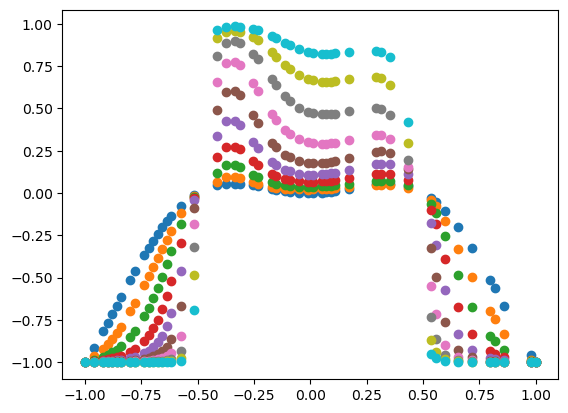

In [196]:
EraseFile(pathOutput)

layers = np.array([2,20,20,20,20,1]) #8 hidden layers

PINN = Sequentialmodel(layers)

Nfeval = 1

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer

list_loss, results= PINN.train(epochs=5000,batch_size=128,epoch_scipy_opt=1000,epoch_print=1000,\
                               resample=False,initial_check=True) #batch_size=128

elapsed = time.time() - start_time                

print("Training time : " + (str(datetime.timedelta(seconds=elapsed))) ) 


In [197]:
#print(results)

#PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)
print(u_pred.shape)

#error_vec = np.linalg.norm((u-u_pred),2)/np.linalg.norm(u,2)        # Relative L2 Norm of the error (Vector)
#print('Test Error: %.5f'  % (error_vec))

 #u_pred = np.reshape(u_pred,(256,100),order='F')                        # Fortran Style ,stacked column wise!

(10000, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(100, 100)


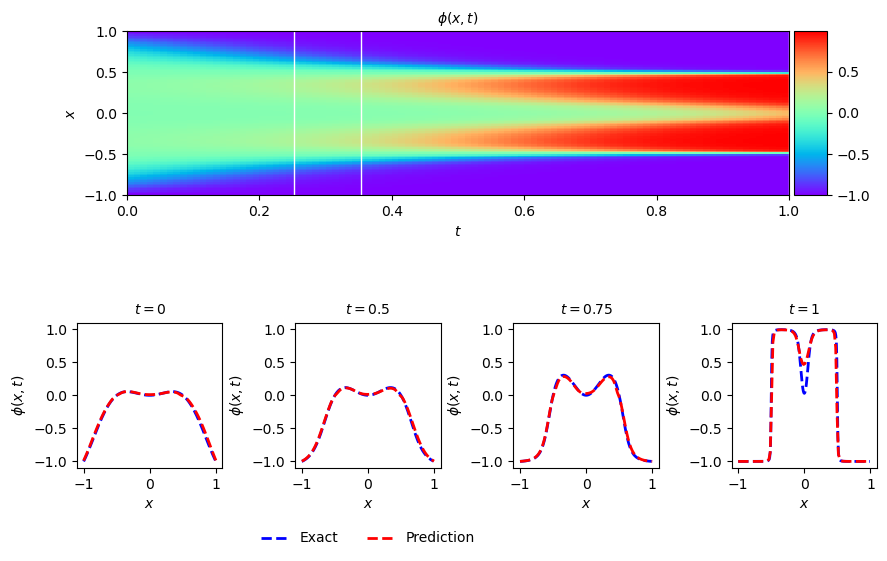

In [199]:
''' Solution Plot '''
u_pred = np.reshape(u_pred,(100 ,100),order='F')   
print(u_pred.shape)
solutionplot(u_pred,X_train_obs)